# 3. word2vec

本章では, 推論ベースの手法として, word2vec を見ていく(前章ではカウントベースの手法を扱った).

## 3.1 推論ベースの手法とニューラルネットワーク

単語をベクトルで表す手法は, 成功を収めたものとして大きく, カウントベースの手法と推論ベースの手法がある. 両者のアプローチは大きく異なるが, その背景には分布仮設がある. ここでは, カウントベースの手法の問題点を指摘し, それに変わる推論ベースの手法の利点を大きな視点で説明する. そして, word2vec への下準備を行うために, ニューラルネットワークで ｢単語｣ を処理する例を見ていく.

### 3.1.1 カウントベースの手法の問題点

カウントベースの手法では, 周囲の単語の頻度によって単語を表現した. しかし, 大きなコーパスを扱う場合には, 例えば語彙数を100万とすれば, 100万 ✕ 100万の巨大な行列を作ることになる. これに対し SVD を行うことは現実的ではない.

カウントベースの手法は, コーパス全体の統計データ (共起行列やPPMIなど) を利用して, 1回の処理で単語の分散表現を獲得する. 一方, 推論ベースの手法では, たとえばニューラルネットワークを用いる場合は, ミニバッチで学習するのが一般的である. この違いを図3-1に表す.

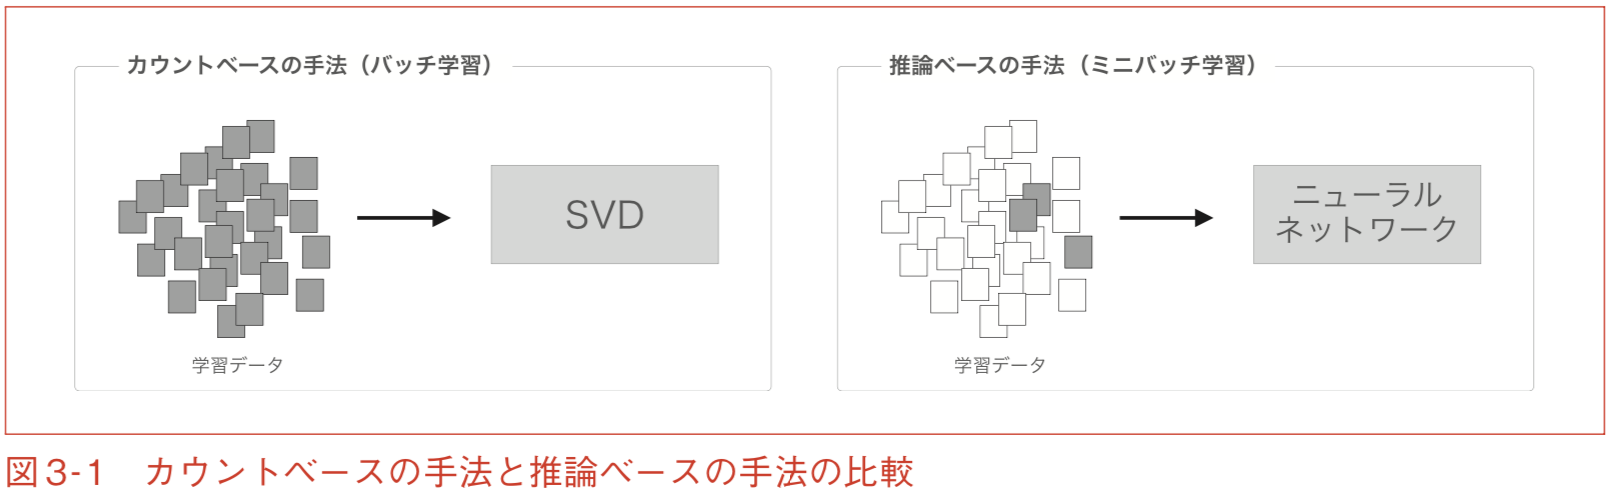

In [1]:
from IPython.display import Image, display
Image('images/NLP/fig3-1.png', width = 600)

### 3.1.2 推論ベースの手法

推論ベースの手法では, 推論することが主な作業になるが, これは図3-2に示すように, 周囲の単語(コンテキスト)が与えられたときに, ｢？｣ にどのような単語が出現するのかを推測する作業である.

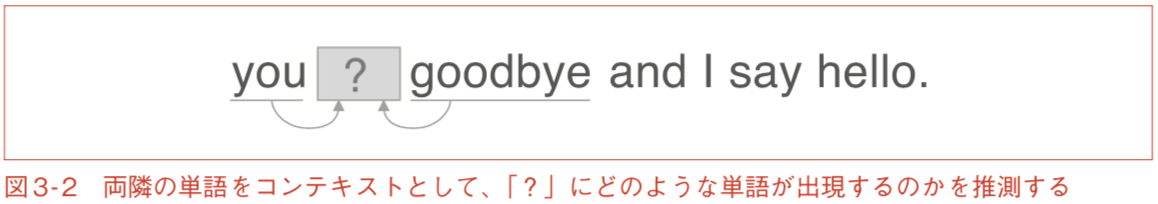

In [2]:
Image('images/NLP/fig3-2.png', width = 500)

このような推論問題を解くこと, そして, 学習することが ｢推論ベースの手法｣ の扱う問題である. このような推論問題を繰り返し解くことで, 単語の出現パターンを学習する. このとき "モデル視点" に立つと, この推論問題は図3-3のように見える.

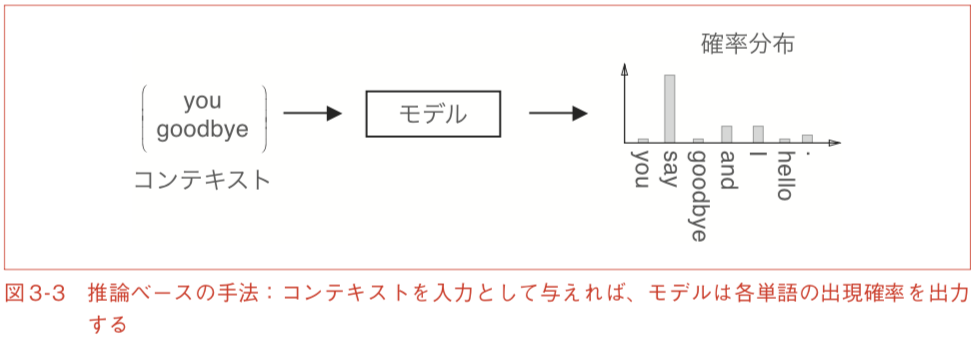

In [3]:
Image('images/NLP/fig3-3.png', width = 600)

このように, 推論ベースの手法では, 何らかのモデルが登場する. 我々は, そのモデルにニューラルネットワークを使う. モデルはコンテキスト情報を入力として受け取り, 出現しうるだろう各単語の出現する確率を出力する. そのような枠組みの中で, 正しい推測ができるように, コーパスを使ってモデルの学習を行う. そして, その学習の結果として, 単語の分散表現を得られるというのが推論ベースの手法の全体図になる.

### 3.1.3 ニューラルネットワークおける単語の処理方法

我々はこれからニューラルネットワークを使って単語を処理する. しかし, ニューラルネットワークは 'you' や 'say' などの単語をそのままでは処理できない. ニューラルネットワークで単語を処理するためには, それは固定長のベクトルに変換する必要がある. そのための方法のひとつは, 単語を one-hot 表現(ベクトル) へと変換することである. ｢You sat goodbye and I say hello. ｣ という1文をコーパスとして扱うとすると, 各単語は図3-4のように one-hot ベクトルへ変換できる.

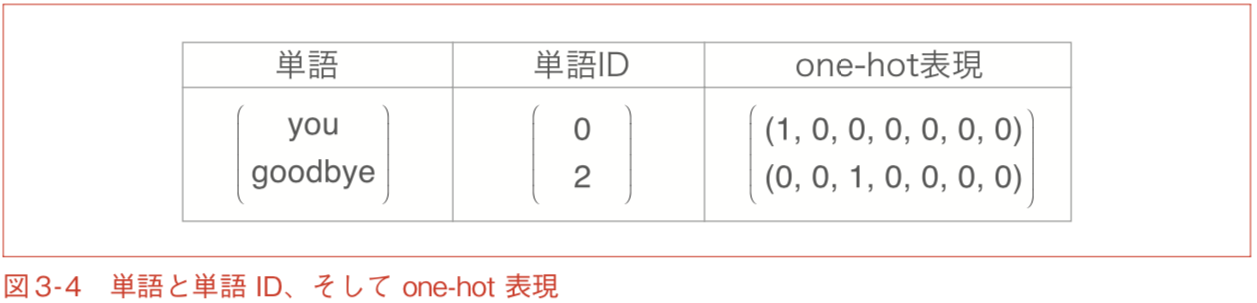

In [4]:
Image('images/NLP/fig3-4.png', width = 550)

このように単語は, テキスト, 単語ID, one-hot 表現でそれぞれ表現できる. このように単語を固定長のベクトルに変換してしまえば, ニューラルネットワークの入力層は, 図3-5のようにニューロンの数を固定することができる.

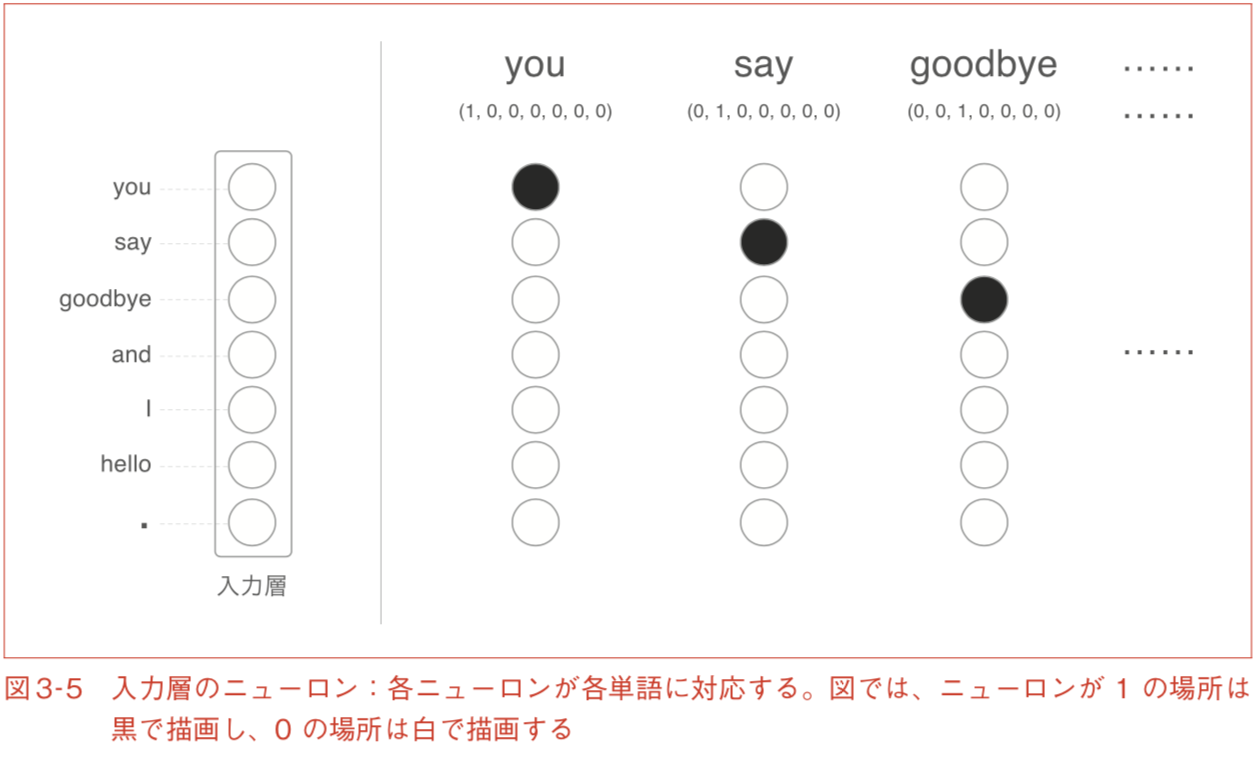

In [5]:
Image('images/NLP/fig3-5.png', width = 600)

図3-5に示すように, 入力層は7つのニューロンによって表される. このとき, 7つのニューロンはそれぞれ7つの単語に対応する.

単語をベクトルで表すことによって, そのベクトルはニューラルネットワークを構成するさまざまなレイヤによって処理することができる. たとえば, one-hot 表現で表されたひとつの単語に対して, 全結合で変換する場合は図3-6のように書くことができる.

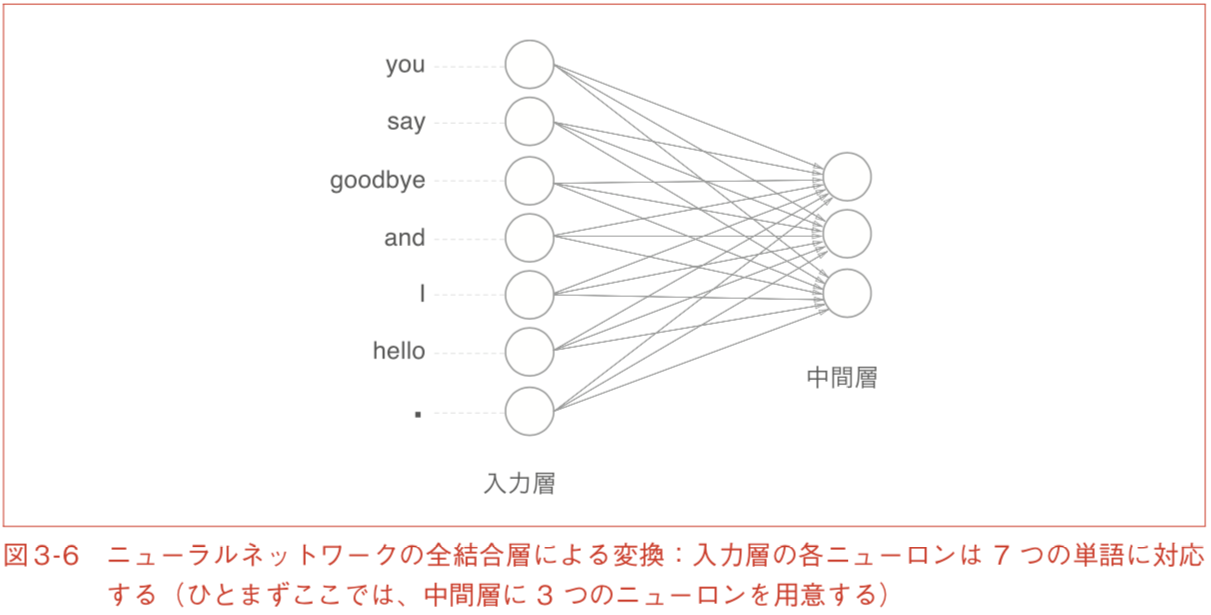

In [6]:
Image('images/NLP/fig3-6.png', width = 600)

図3-6では,  ニューロン間の結びつきを矢印によって図示したが, これ以降は重みを明確に示すため図3-7のような図法を用いることにする.

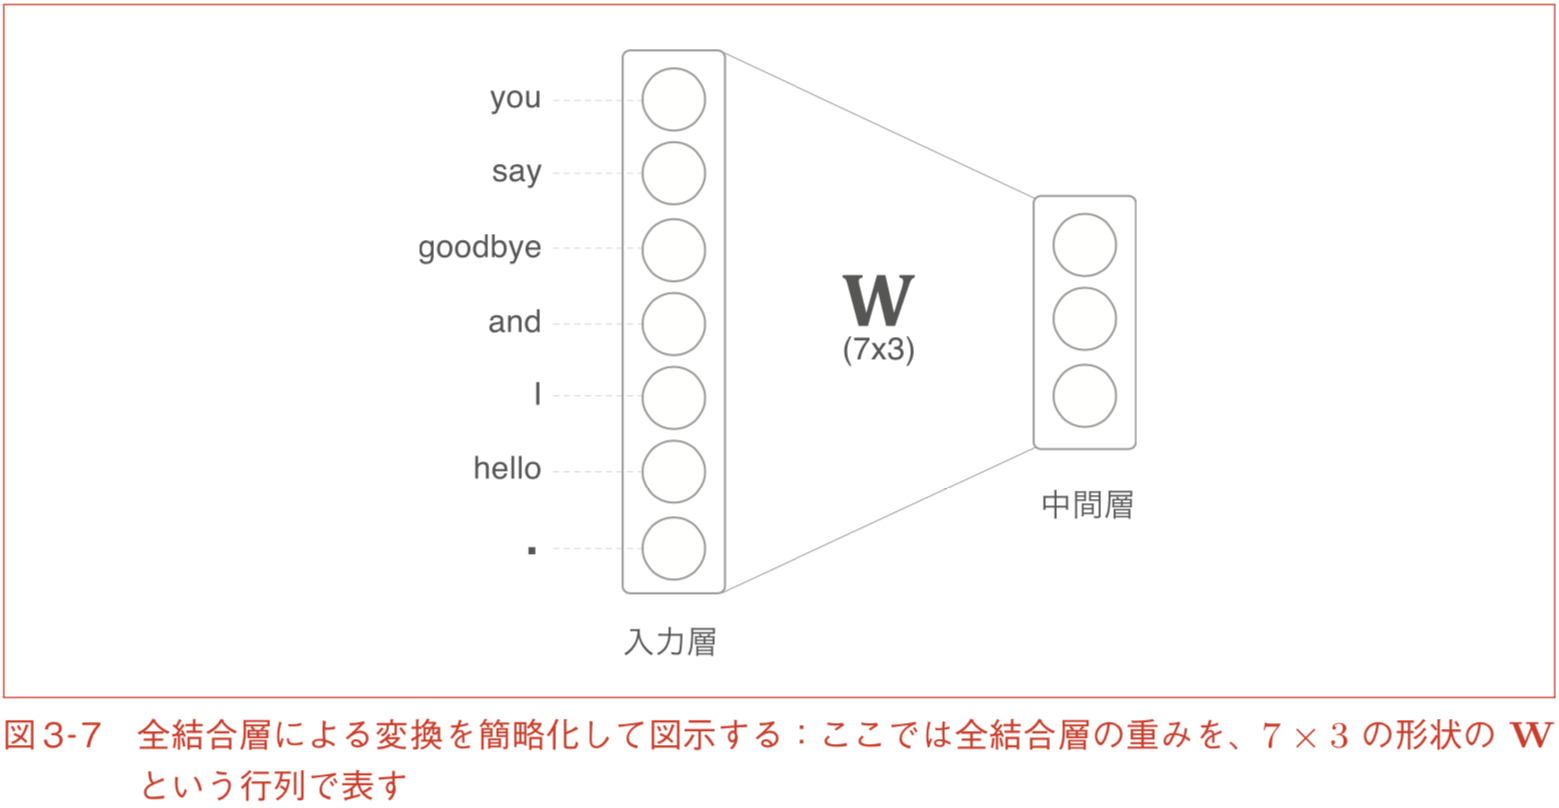

In [7]:
Image('images/NLP/fig3-7.png', width = 600)

全結合層による変換を実装すると次のようになる.

In [8]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 入力
W = np.random.randn(7, 3) # 重み
h = np.dot(c, W) # 中間ノード 
print(h)

[[-1.70916578  0.65440077  0.80093946]]


このコード例では, 単語IDが0の単語を one-hot 表現で表し, それを全結合層によって変換する例を示している. 

c は one-hot 表現であるため, 単語IDに対応する要素が1で, それ以外は0であるベクトルになる. そのため, 上のコードの c と W の行列の積は, 図3-8に示すように, 重みの行ベクトルを抜き出すことに相当する.

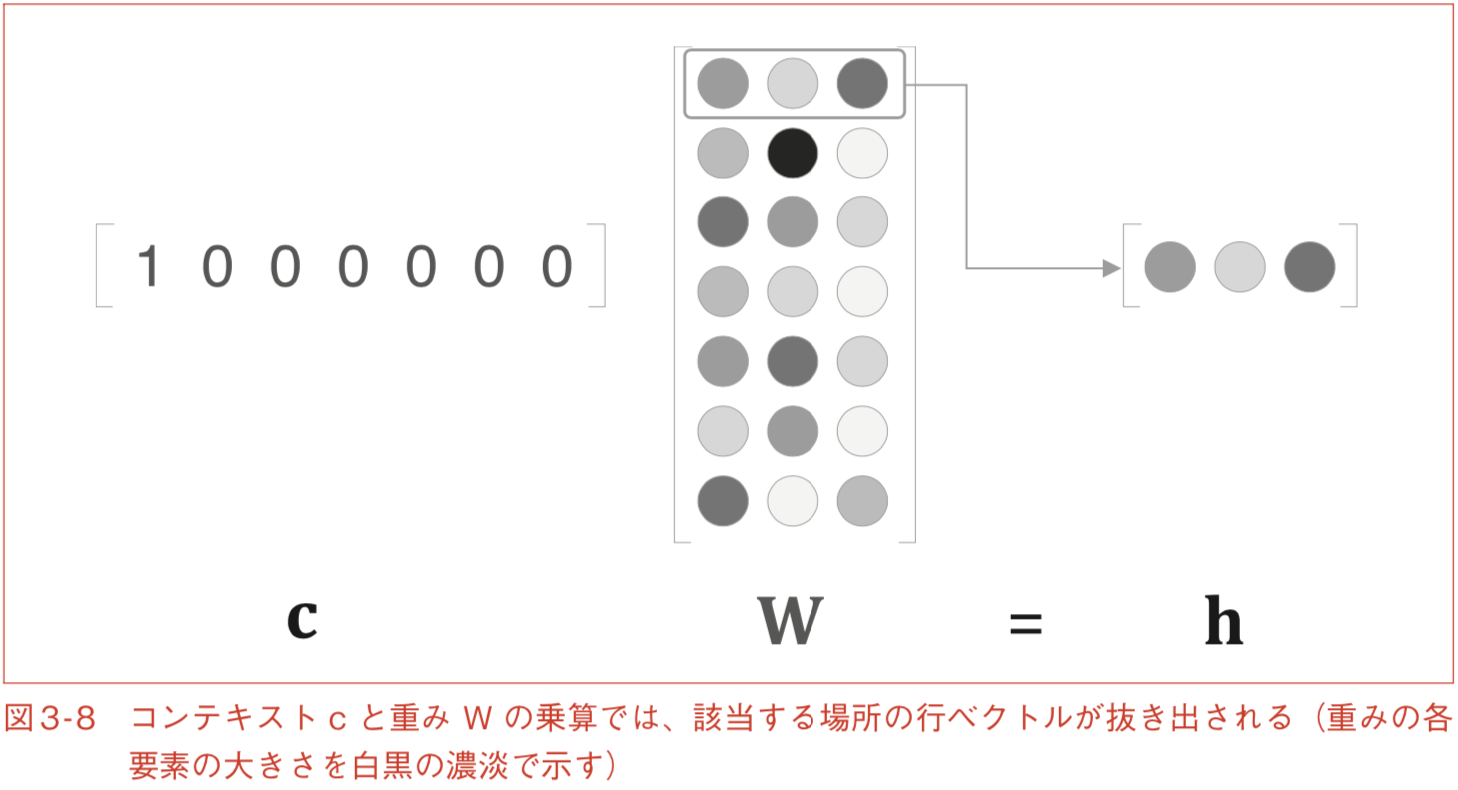

In [9]:
Image('images/NLP/fig3-8.png', width = 600)

## 3.2 シンプルなword2vec

図3-3に示されるモデルにニューラルネットワークを組み込む. ここでは, そのニューラルネットワークに, word2vec で提案されている continuous bag-of-words (CBOW) と呼ばれるモデルを使う.

### 3.2.1 CBOW モデルの推論処理

CBOW モデルは, コンテキスト(周囲の単語)からターゲット(中央の単語)を推測することを目的としたニューラルネットワークである. CBOW モデルへの入力はコンテキストであり, これは, ['you', 'goodbye'] のような単語のリストで表される.それを one-hot 表現に変換することで, CBOW モデルが処理できるように調整する. それを踏まえると, CBOW モデルのネットワークは図3-9のようになる.

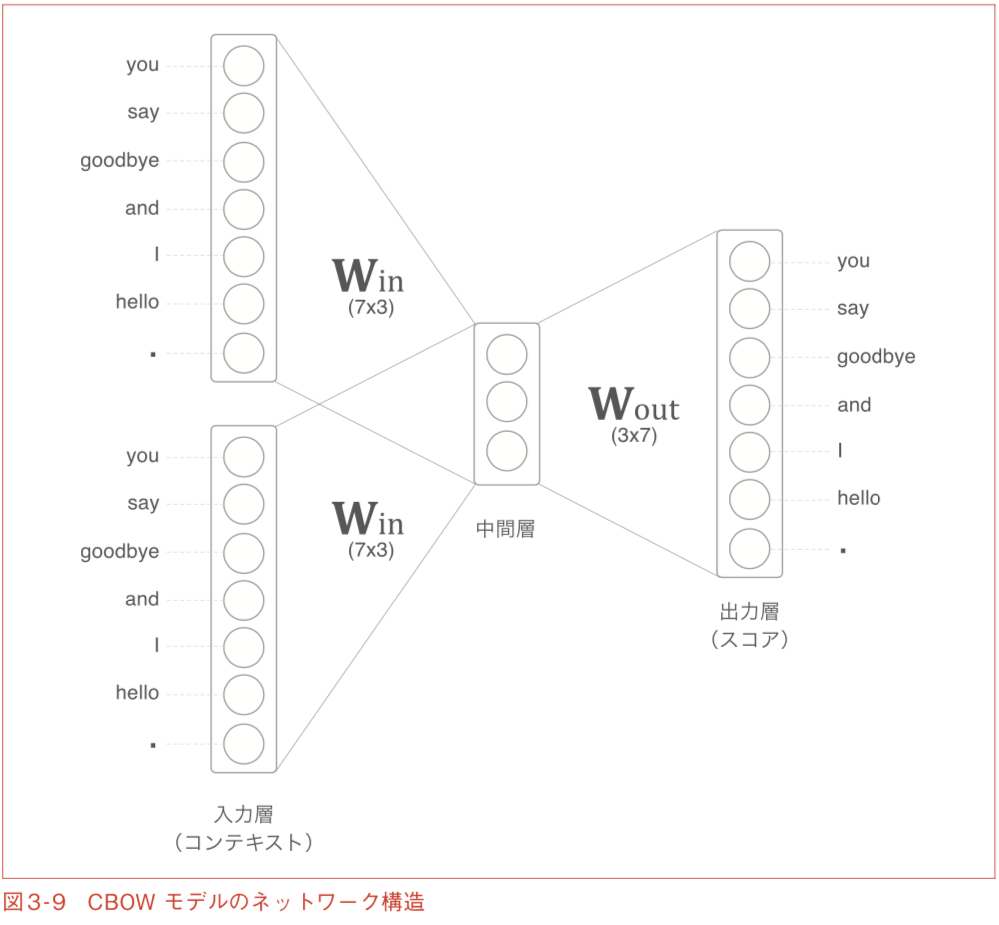

In [10]:
Image('images/NLP/fig3-9.png', width = 600)

図3-9が, CBOW モデルのネットワークである. 入力層が2つあり, 中間層を経て, 出力層へ辿り着く. ここで, 入力層から中間層への変換は, おなじ 
全結合層(重みは $\mathbf{W_{in}}$) によって行われる. そして, 中間層から出力層のニューロンのへの変換は, 別の全結合 (重みは $\mathbf{W_{out}}$) によって行われる.

図3-9の中間層に注目すると, このとき, 中間層にあるニューロンは, 各入力層の全結合による変換後の値が平均されたものになる. 上の例で言えば, 全結合によってひとつ目の入力層が $\mathbf{h_1}$ に, 2つ目の入力層が $\mathbf{h_2}$ に変換されたとすると, 中間層のニューロンは $\frac{1}{2}(\mathbf{h_1} + \mathbf{h_2})$ となる.

最後に図3-9の出力層についてであるが, この出力層には7個のニューロンがあり, ここで重要なのが, それらのニューロンは各単語に対応しているということである. そして出力層のニューロンは各単語のスコアであり, その値が高ければ高いほど, それに対応する単語の出現確率も高くなる. なお, スコアは確率として解釈される前の値であり, このスコアに Softmax 関数を適用することで確率が得られる.

図3-9のとおり, 入力層から中間層への変換は, 全結合層 (重みは $\mathbf{W_{in}}$) によって行われる. このとき, 全結合層の重み $\mathbf{W_{in}}$ は $7 \times 3$ の形状の行列であるが, この重みこそ単語の分散表現である. これは図で表すと図3-10のようになる.

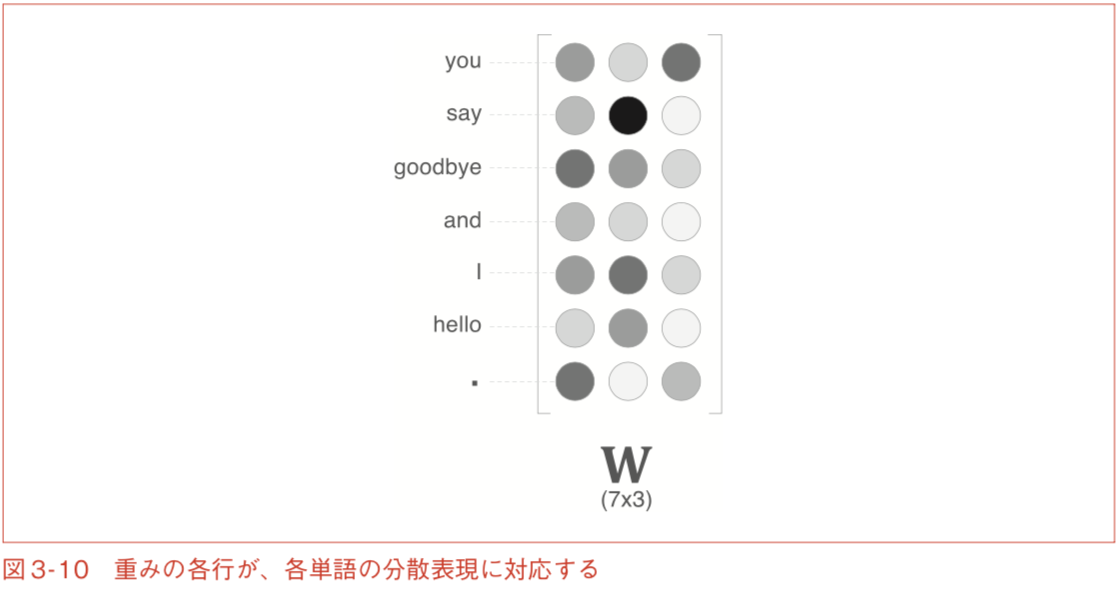

In [11]:
Image('images/NLP/fig3-10.png', width = 600)

図3-10に示すように, 重み $\mathbf{W_{in}}$ の各行にはそれぞれの単語の分散表現が格納されていると考える. そして学習を重ねることで, コンテキストから出現する単語をうまく推測できるように各単語の分散表現が更新されていく. このようにして得られたベクトルには ｢単語の意味｣ もうまくエンコードされている. これが word2vec の全体像である.

中間層のニューロンの数を入力層のニューロンの数よりも減らすことが重要であり, それによって中間層には, 単語を予測するために必要な情報をコンパクトに収める必要があり, 結果として密なベクトル表現が得られる. このとき, その中間層の情報は, 我々人間にとって理解できないコードで書かれている. これはエンコードという作業に相当する. 一方, 中間層の情報から目的の結果を得る作業はデコードと言い, これは, エンコードされた情報を人間が理解できる表現へと復元する作業である.

これまで, CBOW モデルをニューロン視点で図示してきたが, ここではレイヤ視点で図示してみる. 以下の図3-11のようになる.

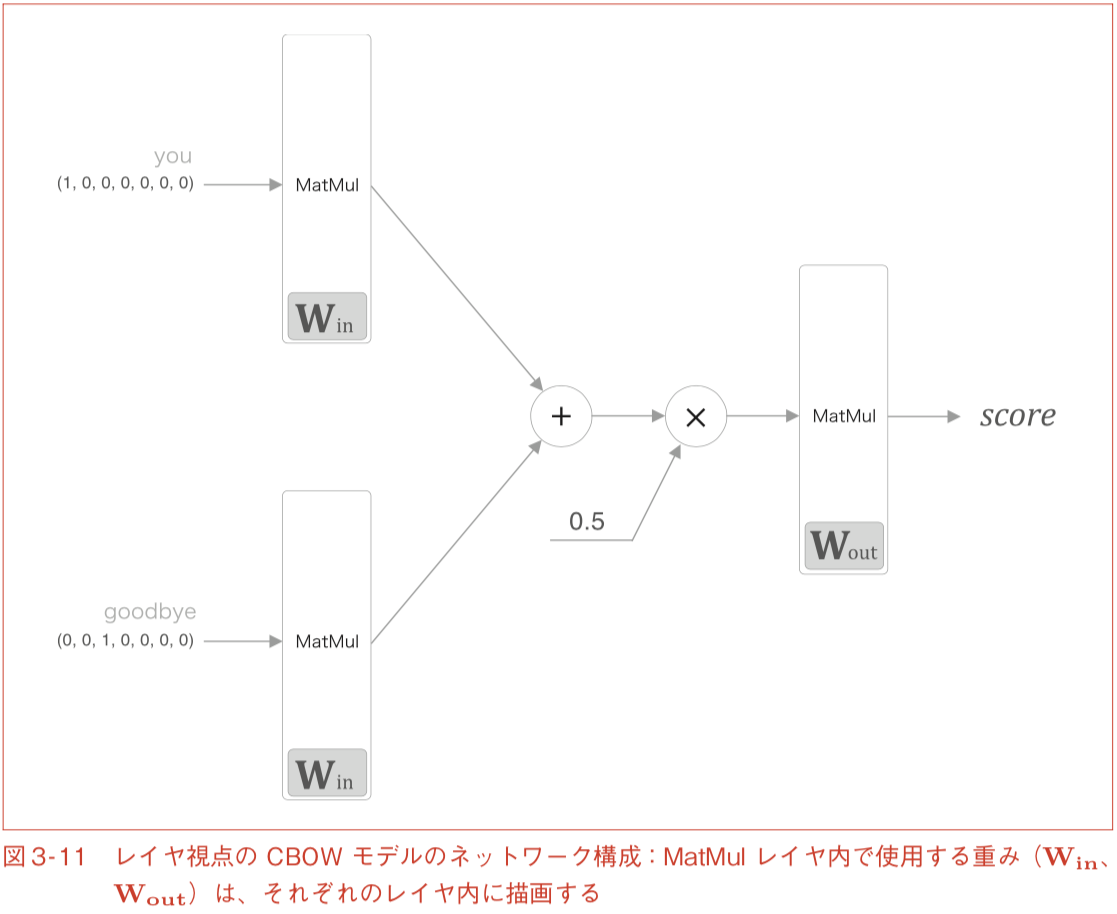

In [12]:
Image('images/NLP/fig3-11.png', width = 600)

図｣3-11のように, CBOW モデルは最初に2つの MatMul レイヤがあり, その2つの出力が互いに加算される. そして, その加算された値に 0.5 を乗算することで, 平均が求められ, それが中間層のニューロンとなる. 最後にその中間層のニューロンに対して, 別の MatMul レイヤが適用されスコアが出力される.

図3-11を参考に, CBOW モデルの推論処理(スコアを求める処理)を実装する. 

In [13]:
class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x): 
        W, = self.params 
        out = np.dot(x, W) 
        self.x = x
        return out
    
    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout) 
        self.grads[0][...] = dW 
        return dx

In [14]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]]) 
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3) 
W_out = np.random.randn(3, 7)

# レイヤの生成
in_layer0 = MatMul(W_in) 
in_layer1 = MatMul(W_in) 
out_layer = MatMul(W_out)

# 順伝播
h0 = in_layer0.forward(c0) 
h1 = in_layer1.forward(c1) 
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)
print(s)

[[ 1.59383452  0.25064458 -0.0827954  -0.08616345  1.30978451 -0.42687678
   0.29387987]]


ここでは最初に, 必要な重み (W_in と W_out) を初期化し, 入力層を処理する MatMul レイヤをコンテキストの数だけ (ここでは2つ) 生成し, 出力層側の MatMul レイヤはひとつだけ生成する. このとき, 入力層側の MatMul レイヤは重み W_in を共有する点に注意が必要である. 後は, 入力層側の MatMul レイヤの forward() メソッドを呼び, 中間データを計算し, 出力層側の MatMul レイヤによって各単語のスコアを求める. 以上が CBOW モデルの推論処理である. CBOW モデルは活性化関数を使わないシンプルなネットワーク構成である. 入力層が複数あり,そこでの重みを共有することにのみ注意が必要である. 


### 3.2.2 CBOW モデルの学習

出力層において各単語のスコアを出力し, このスコアに対して Softmax 関数を適用することで, ｢確率｣ を得ることができる (図3-12). この確率は, コンテキストが与えられたときに, その中央にどの単語が出現するのかを表す.

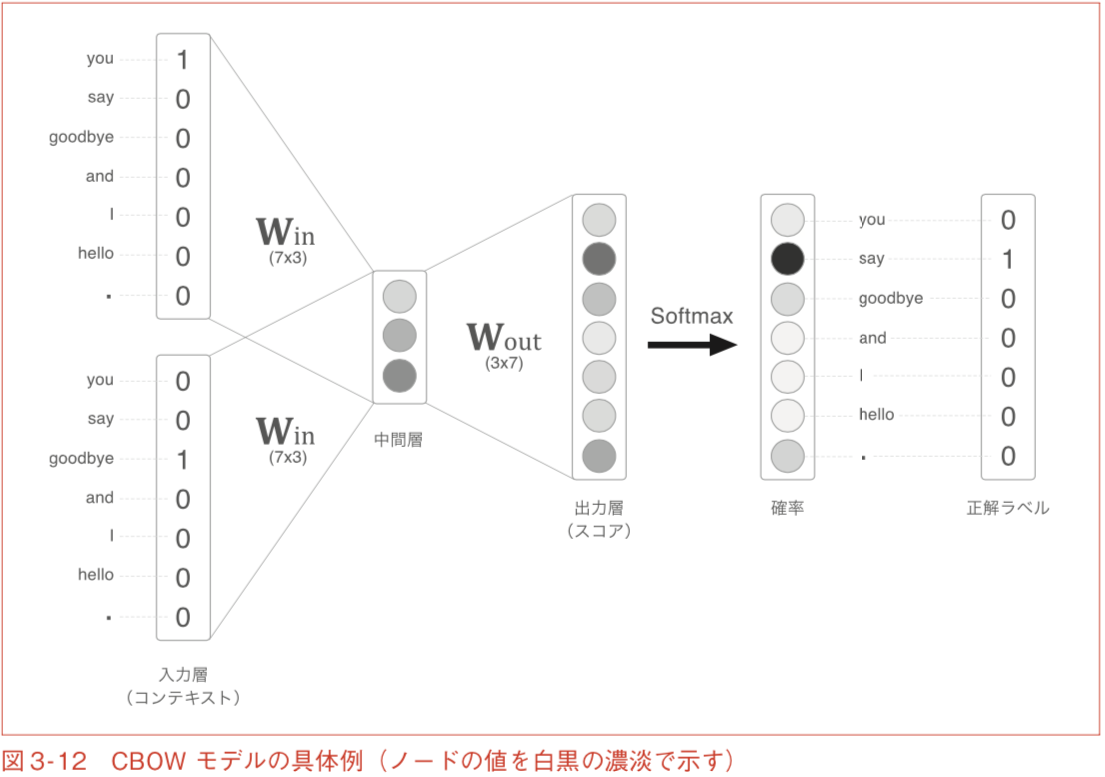

In [15]:
Image('images/NLP/fig3-12.png', width = 600)

図3-12で表す例は, コンテキストは ｢you｣ と ｢goodbye｣, 正解ラベル(ニューラルネットワークが予測すべき単語)は ｢say｣ である例である. このとき, 適切な重みのネットワークがあれば, 確率を表すニューロンにおいて, 正確に対応するニューロンが高くなっていることが期待できる.

CBOW モデルの学習で行うことは, 正しい予測ができるように重みを調整することであり, その結果として, 重みの $\mathbf{W_{in}}$ に, 正確には $\mathbf{W_{in}}$ と $\mathbf{W_{out}}$ の両方に, 単語の出現パターンを捉えたベクトルが学習される. そしてこれまでの実験によって, CBOW モデル (とskip-gram モデル) で得られる単語の分散表現は, 特にWikipediaなどの大規模コーパスを使って得られる単語の分散表現は, 単語の意味的な点や文法的な点において, 我々の直感と合致するケースが多く見られる.

上の多クラス分類を行うニューラルネットワークの学習では, Softmax と 交差エントロピー誤差を用いる. スコアを Softmax で確率に変換し, その確率と教師ラベルから交差エントロピー誤差を求め, それを損失として学習を行う. これを図で表すと図3-13のようになる. 

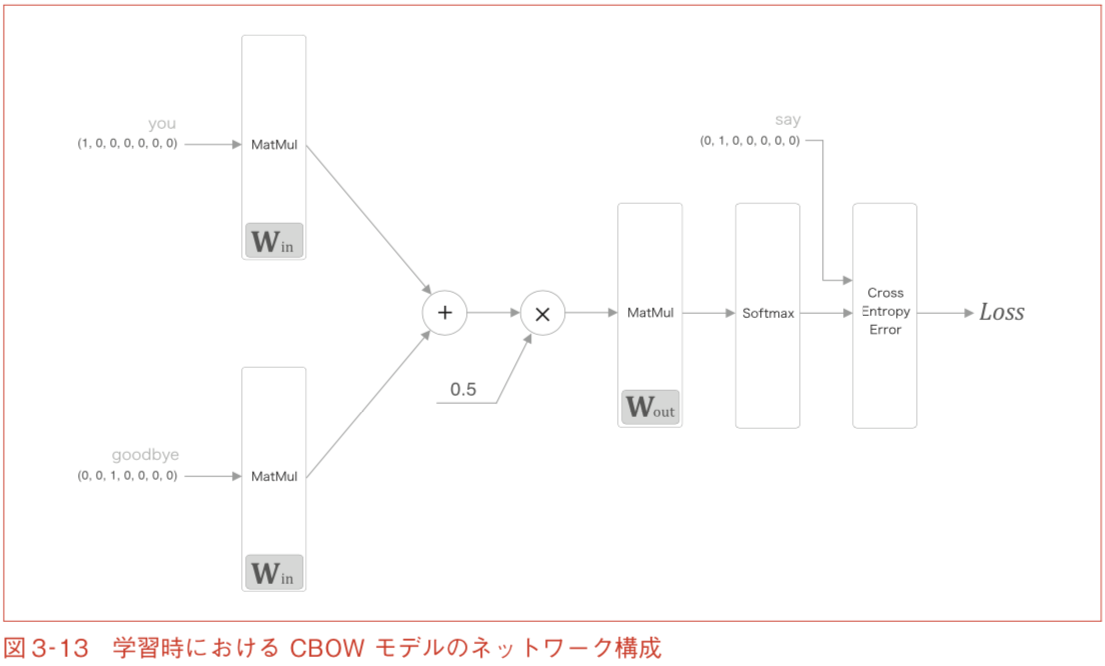

In [16]:
Image('images/NLP/fig3-13.png', width = 600)

図3-13のとおり, 推論処理を行う CBOW モデルに対し, Softmax レイヤと Cross Entropy Error レイヤを追加するだけで, 損失を得ることができる. 以上が CBOW モデルの損失を求める計算の流れであり, これがニューラルネットワークの順方向の伝搬である.

なお, 図3-13では Softmax レイヤと Cross Entropy Error レイヤを用いたが, その2つのレイヤを Softmax-with-Loss レイヤというひとつのレイヤで実装している. そのため, これから実装するネットワークは正確には, 図3-14のように書ける. 

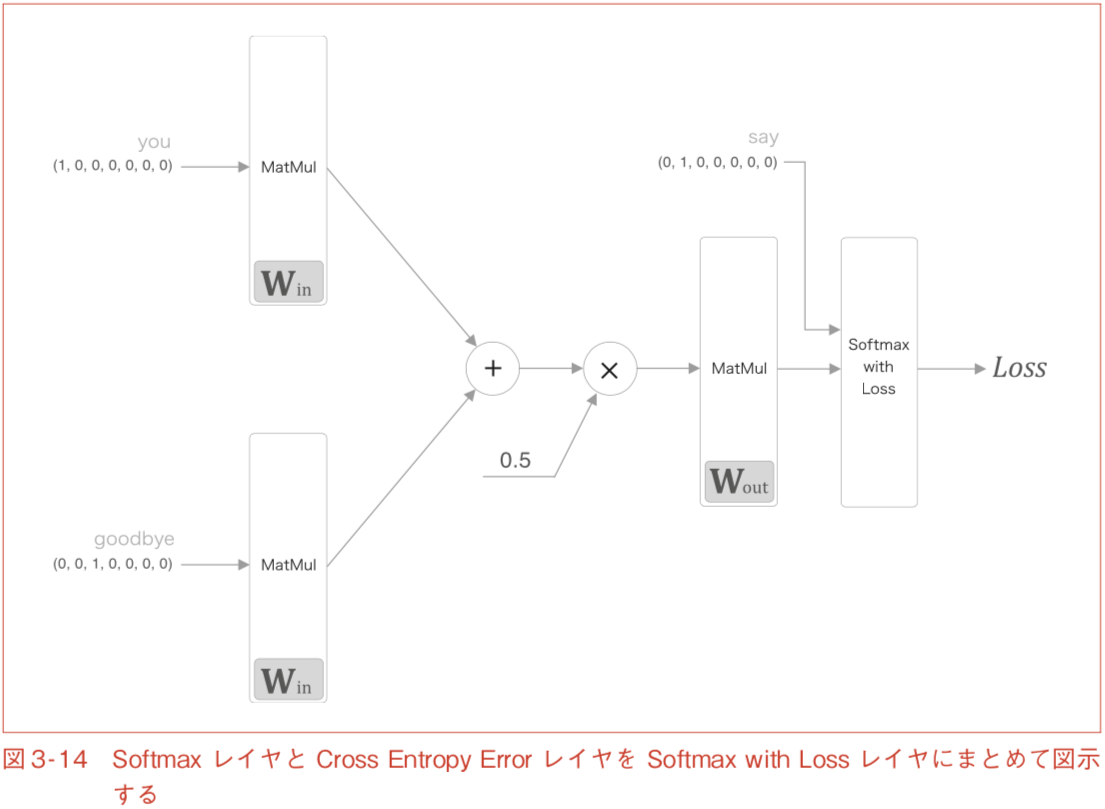

In [17]:
Image('images/NLP/fig3-14.png', width = 600)

### 3.2.3 word2vec の重みと分散表現

word2vec で使用されるネットワークには2つの重みがあり, それは入力層の全結合の重み ($\mathbf{W_{in}}$) と, 出力側の全結合層の重み ($\mathbf{W_{out}}$) である. そして, 入力側の重みの各行が, 各単語の分散表現に対応し, 出力側の重みについても, 単語の意味がエンコードされたベクトルが格納されていると考えることができる. ただし, 出力側の重みは, 図3-15に示すように列方向に各単語の分散表現が格納されている.

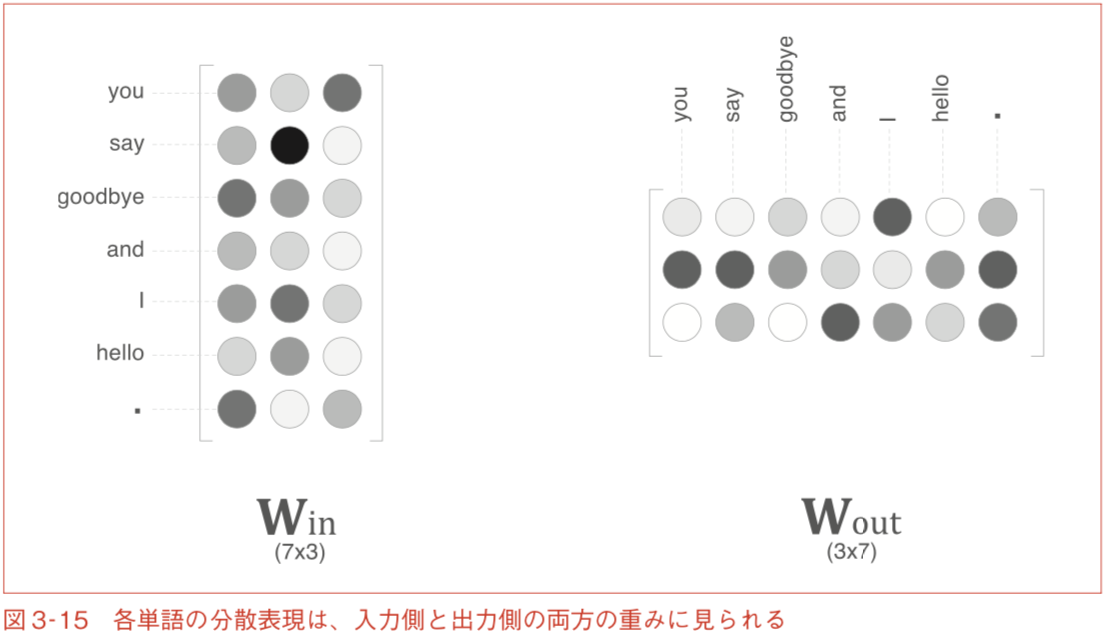

In [18]:
Image('images/NLP/fig3-15.png', width = 600)

word2vec に関して言えば, 入力側の重みだけを利用するというのが最もポピュラーな選択肢であり, 多くの研究では, 出力側の重みは利用せずに入力側の重みだけを最終的な単語の分散表現として利用する. ここでも, 入力側の重みだけを単語の分散表現として利用する.

## 3.3 学習データの準備

｢You say goodbye and I say hello.｣ という1文をコーパスとして利用する.

### 3.3.1 コンテキストとターゲット

word2vec で用いるニューラルネットワークの入力はコンテキストであり, その正解ラベルは, コンテキストに囲まれた中央の単語 (ターゲット) になる. つまり, ニューラルネットワークにコンテキストを入力したときにターゲットが出現する確率を高くすれば良い(そうなるように学習を行う).

図3-16のように, コーパスからコンテキストとターゲットを作ることを考える.

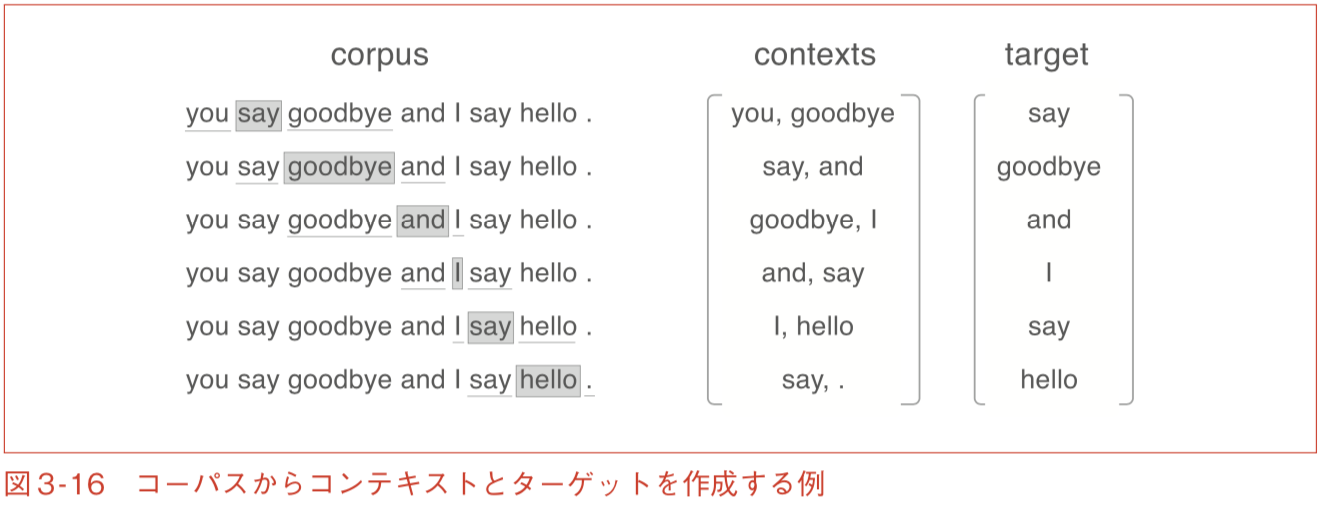

In [19]:
Image('images/NLP/fig3-16.png', width = 600)

図3-16では, コーパス中から対象とする単語をターゲットとして, その周囲の単語をコンテキストとして抜き出す. その作業をコーパス中のすべての単語に対して行う. このようにして作られたのが, 図3-16の右側にある contexts と target である. この contexts の各行がニューラルネットワークの入力になり, target の各行が正解ラベル (予測すべき単語) となる. なお, 各サンプルデータにおいて, コンテキストは複数あり (この例では2個), ターゲットはひとつだけである. そのため, コンテキストだけ contexts と複数にしている.  

これから, コーパスからコンテキストとターゲットを作成する関数を実装する. まずは, コーパスのテキストを単語IDに変換するところから行う.

In [20]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .') 
    words = text.split(' ')
    word_to_id = {} 
    id_to_word = {} 
    
    for word in words:
        if word not in word_to_id: 
            new_id = len(word_to_id) 
            word_to_id[word] = new_id 
            id_to_word[new_id] = word
        
    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [21]:
text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text) 

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


この単語IDの配列である corpus から, contexts と target を作る. 具体的には, 図3-17に示すように, corpus を与えると, contexts と target を返す関数を実装する.

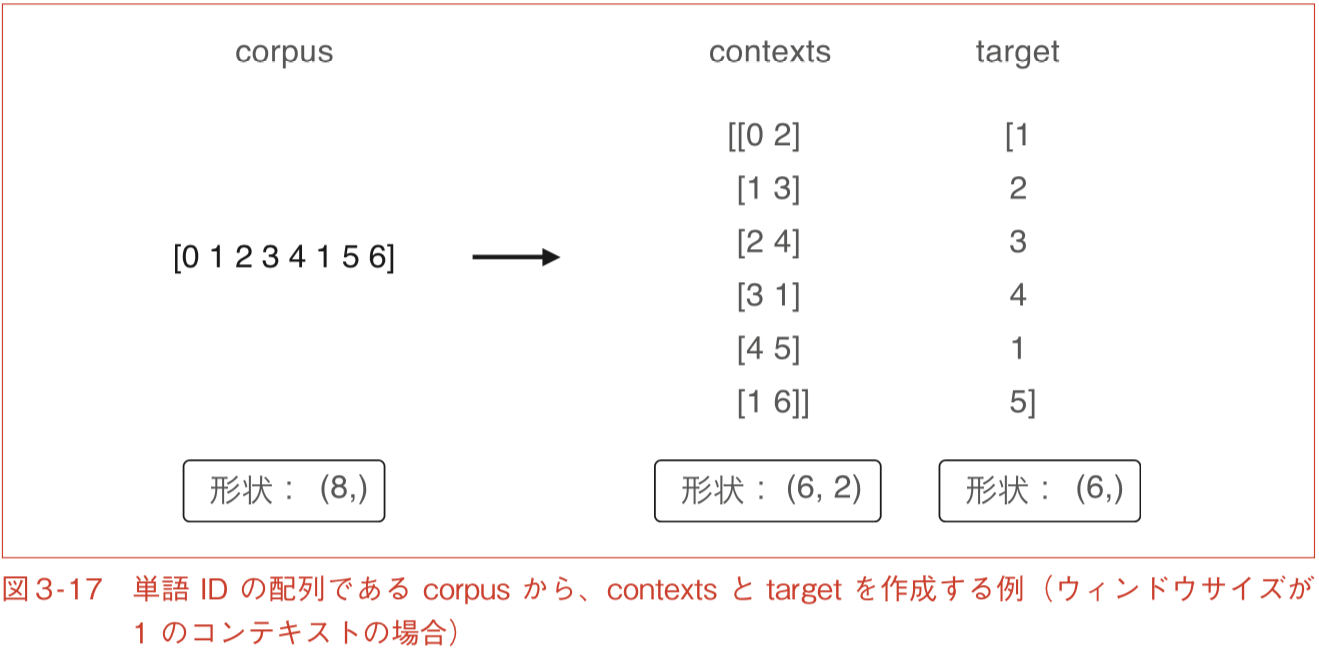

In [22]:
Image('images/NLP/fig3-17.png', width = 600)

図3-17に示すように, contexts は2次元配列であり， contexts の 0次元目にはコンテキストデータが格納される. 具体的に言うと, contexts[0] は0番目のコンテキスト, contexts[1] は1番目のコンテキスト･･････となる.

同様に, ターゲットについても, target[0] は0番目のターゲット, target[1] は1番目のターゲット････と格納される.

このコンテキストとターゲットを作成する関数を実装する.

In [23]:
def create_contexts_target(corpus, window_size=1): 
    target = corpus[window_size:-window_size] 
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size): 
        cs = []
        for t in range(-window_size, window_size + 1): 
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

この関数は引数を2つとり, ひとつは単語IDの配列 (corpus), もうひとつはコンテキストのウインドウサイズ (window_size) である. そして, コンテキストとターゲットをそれぞれ NumPy の多次元配列として返す. 実際に使ってみる.

In [24]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


これで, コーパスからコンテキストとターゲットを作ることができた. 後は, これをCBOW モデルに与えるだけである. ただし, このコンテキストとターゲットの各要素は単語IDのままであるから, これを one-hot 表現に変換する.

### 3.3.2 one-hot 表現への変換

コンテキストとターゲットを one-hot 表現へ変換する. この変換は図3-18のようになる.

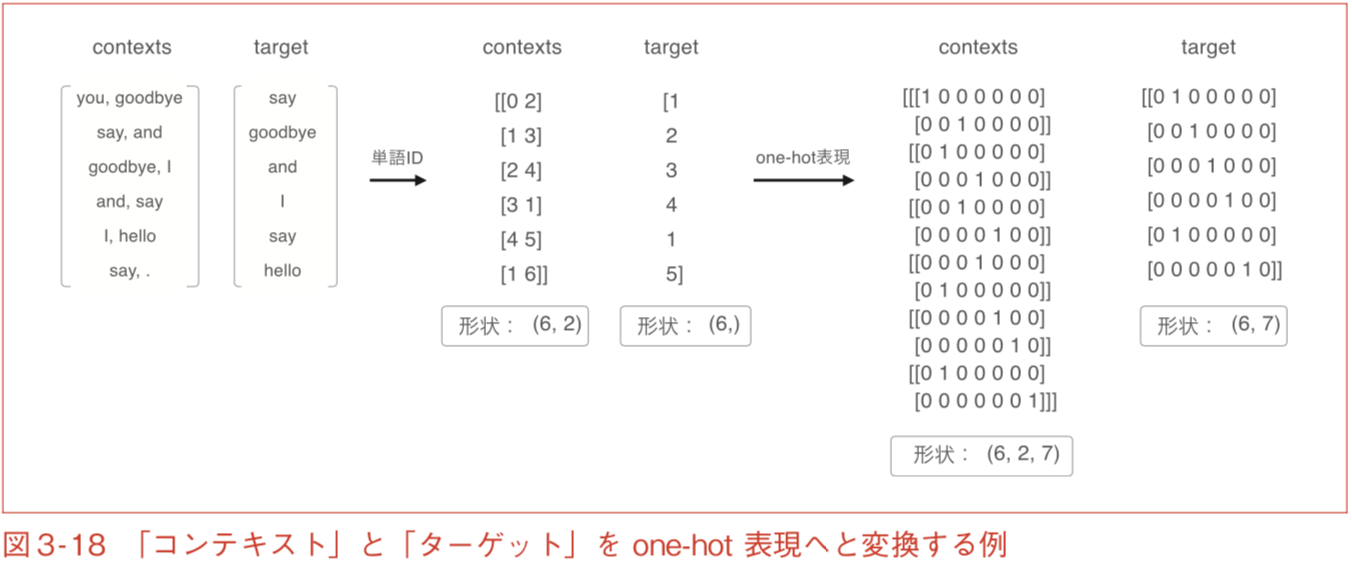

In [25]:
Image('images/NLP/fig3-18.png', width = 600)

図3-18のとおり, コンテキストとターゲットを単語IDから one-hot 表現へと変換する. ここでは, それぞれの多次元配列の形状に注目して, たとえば上の例で, 単語IDを利用したときの contexts の形状は (6, 2) であるが, それを one-hot 表現に変換すると (6, 2, 7) となる. 変換と, データの準備の処理をまとめて書くと次のようになる.

In [26]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換

    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [27]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

print(target)
print(contexts)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


## 3.4 CBOW モデルの実装

ここで実装するニューラルネットワークは図3-19のようになる.

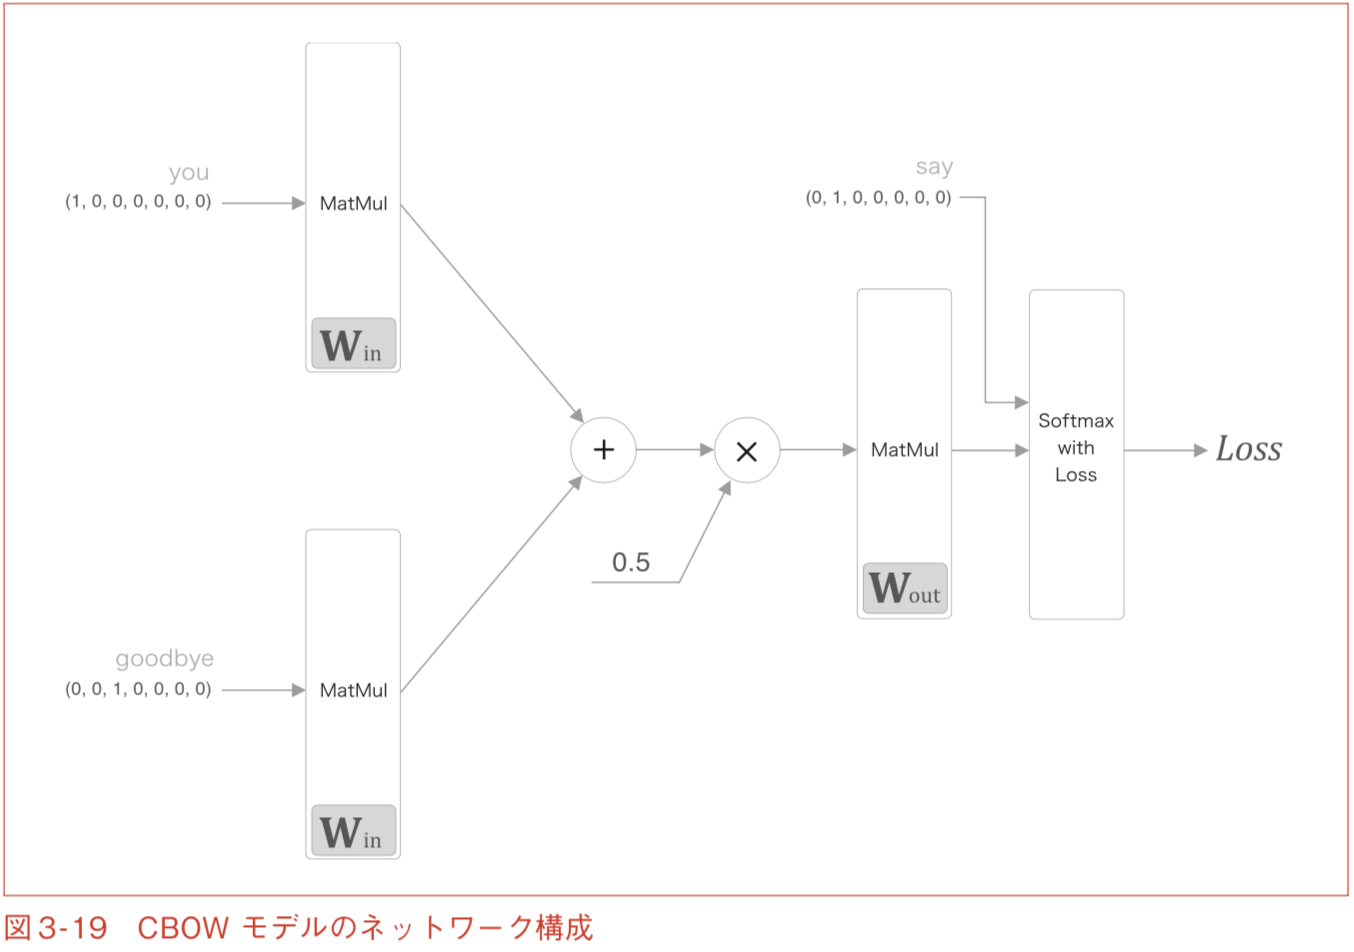

In [28]:
Image('images/NLP/fig3-19.png', width = 600)

まずイニシャライザを示す.

In [29]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

ここでは, イニシャライザの引数として, 語彙数の vocab_size と中間層のニューロン数の hidden_size を取る. まずは重みの初期化についてであるが, ここでは重みを2つ生成する($\mathbf{W_{in}}$ と $\mathbf{W_{out}}$). この2つの重みはそれぞれ, 小さなランダム値によって初期化する. また, このとき NumPy の配列のデータ型を astype('f') で指定する. これによって, 32ビットの浮動小数点で初期化される.

続いて必要なレイヤを作成する. ,まずは入力側の MatMul レイヤを2つ, 出力側の MatMul レイヤをひとつ, Softmax-with-Loss レイヤをひとつ生成する. ここで入力側のコンテキストを処理する MatMul レイヤは, コンテキストで使用する単語の数だけ作る(この例では2つ). そして同じ重みを利用するように, MatMul レイヤを初期化する.

最後に, このニューラルネットワークで使われるパラメータと勾配をメンバ変数の params と grads に配列としてそれぞれまとめる.

続いて, ニューラルネットワークの順伝搬である forward() メソッドを実装する. このメソッドは, 引数として contexts と target の2つを取り, 損失 (loss) を返す.

In [30]:
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

ここで引数の contexts は3次元の NumPy 配列であることを想定する. これは, 図3-18 の例では (6, 2, 7) の形状になり, その0番目の次元の要素数はミニバッチの数だけ存在し, 1番目の次元の要素数はコンテキストのウィンドウサイズ分だけある. そして, 2番目の次元は one-hot ベクトルで表され, また, target の形状は2次元であり, これはたとえば, (6, 7) のような形状になる.
最後に, 逆伝播の backward() を実装する. この逆伝播の計算グラフは図3-20のようになる.

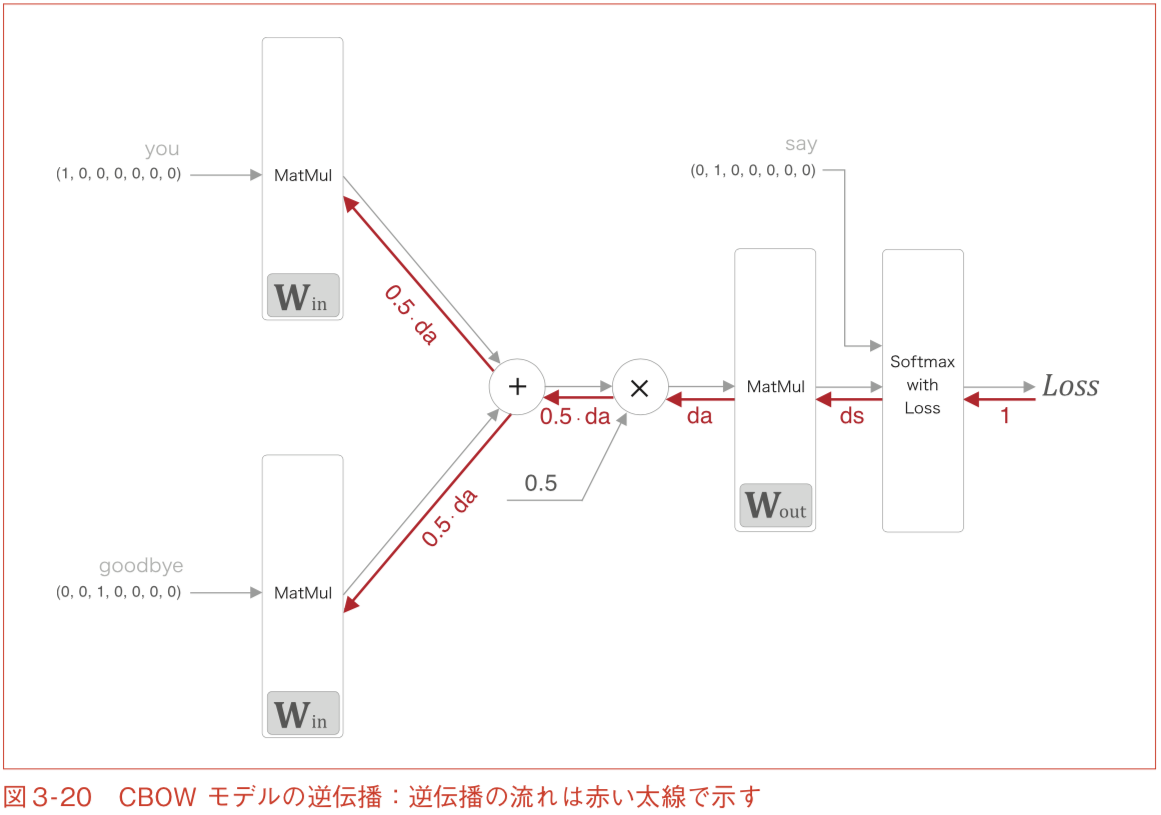

In [31]:
Image('images/NLP/fig3-20.png', width = 600)

ニューラルネットワークの逆伝搬は, 勾配を順伝搬とは逆方向に伝搬する. この逆伝搬は ｢1｣ からスタートし, それを Softmax-with-Loss レイヤへ入力する. そして, Softmax-with-Loss レイヤの逆伝搬の出力を ds として, その ds を出力側の MatMul レイヤへと入力する. 後は, ｢+｣ と ｢✕｣ の演算の逆伝搬になり, ｢✕｣ の逆伝搬は, 順伝搬時の入力値を入れ替えて勾配に乗算し, ｢+｣ の逆伝搬は, 勾配をそのまま通すだけである. 以下で実装する.

In [32]:
def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

各パラメータの勾配をメンバ変数の grads にまとめているため, forward() メソッドを呼び, 続けて backward() メソッドを呼ぶことで, grads 配列にある勾配が更新される.

### 3.4.1 学習コードの実装

CBOW モデルの学習は, 通常のニューラルネットワークの学習とまったく同じである. まずは学習データを準備して, ニューラルネットワークに与える. そして勾配を求めて, 重みパラメータを逐一アップデートしていく. 学習のための実装は以下のとおりである.

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 492 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 493 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 494 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 495 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 496 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 497 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 498 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 499 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 500 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 501 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 502 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 503 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 504 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 505 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 506 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 507 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 508 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 509 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 510 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 511 |  iter 1 / 2 | time 0[s] | loss 0.80


| epoch 961 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 962 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 963 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 964 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 965 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 966 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 967 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 968 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 969 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 970 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 971 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 972 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 973 |  iter 1 / 2 | time 0[s] | loss 0.41
| epoch 974 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 975 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 976 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 977 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 978 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 979 |  iter 1 / 2 | time 0[s] | loss 0.40
| epoch 980 |  iter 1 / 2 | time 0[s] | loss 0.67


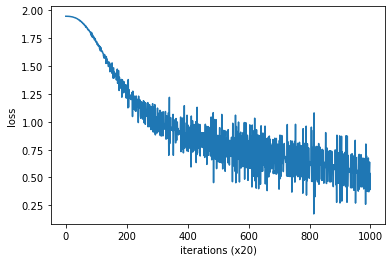

In [38]:
import sys
sys.path.append('..')  # 親ディレクトリのファイルをインポートするための設定
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

上図のとおり, 学習回数を重ねるごとに, 損失が減少している事がわかる. 学習が終わった後の重みパラメータを見てみる. ここでは, 入力側の MatMul レイヤの重みを取り出し, 実際に中身を確認してみる.

In [34]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.8652649   1.4875664   0.8511521   0.86537814  1.6330655 ]
say [ 1.3110105  0.6300047 -0.7151193 -1.2919327  1.1696622]
goodbye [-1.175403   -0.04854709  1.18482     1.2160257  -0.29054603]
and [ 0.8179085   1.7064519  -1.6690297  -0.8286808   0.35080114]
i [-1.1838785  -0.04678864  1.1940203   1.2228421  -0.2855874 ]
hello [-0.87339324  1.4897047   0.8474386   0.84891146  1.6252785 ]
. [ 1.3410941 -1.4337113  1.7035539 -1.3205763  1.3901058]


ここでは, word_vecs という名前で重みを取り出す. 各行には対応する単語IDの分散表現が格納されている. これで単語を密なベクトルで表すことに成功した. しかし, コーパスのサイズが小さいため, 良い結果を得られるとは言えず, 大きくすれば処理速度の面で問題が発生する. 次章で現状のシンプルな CBOW モデルに対して改良を加え, 本物の CBOW モデルを実装する.

## 3.5 word2vec に関する補足

まずはCBOW モデルについて, 確率の視点からもう一度考える.

### 3.5.1 CBOW モデルと確率

確率を $P(\cdot)$のように表す. たとえば, $A$ という事象が起こる確率は, $P(A)$ のように書く. また, 同時確率は $P(A, B)$のように書く. 事後確率は $P(A|B)$ のように書く. 

CBOW モデルを確率の表記によって記述する. CBOW モデルが行うことは, コンテキストを与えるとターゲットとなる単語の確率を出力することである. ここでは, $w_1, w_2, ..., w_T$ という単語の列で表されるコーパスを扱うことにし, 図3-22のように, $t$ 番目の単語に対して, ウインドウサイズが1のコンテキストを考える.

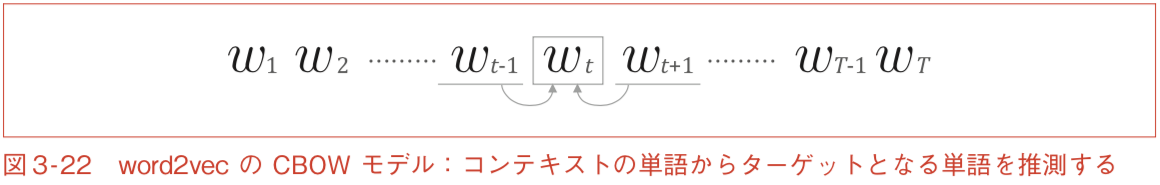

In [35]:
Image('images/NLP/fig3-22.png', width = 600)

コンテキストとして, $w_{t-1}$ と $w_{t+1}$ が与えれたときに, ターゲットが $w_t$ となる確率を数式で表す.

$$
    P(w_t|w_{t-1}, w_{t+1}) \tag{3.1}
$$

式(3.1)は, $w_{t−1}$ と $w_{t+1}$ が起こった後に $w_t$ が起こる確率」を表し, それは, 「$w_{t−1}$ と $w_{t+1}$ が与えられたときに $w_t$ が起こる確率｣ と解釈できるから, CBOWモデル は式(3.1)はをモデル化しているということである.

ここで式(3.1)を用いれば, CBOW モデルの損失関数も簡潔に表すことができる. それには, 交差エントロピー誤差の式

$$
    L = -\sum_{k}t_k \log{y_k} \tag{1.7}
$$

を当てはめる. $y_k$ は $k$ 番目に対応する事象が起こる確率を表す. ここでの問題は, $w_k$ が起こる事象が正解であるため, それに対応する one-hot ベクトルの要素が1で, それ以外は0になる. その点を考慮すると, 次の式が解ける

$$
    L = - \log{P}(w_t|w_{t-1}, w_{t+1}) \tag{3.2}
$$

CBOW モデルの損失関数は, 単に式(3.1)の確率に対し $\log$をとり, マイナスをつけたものになる. これは, 負の対数尤度と呼ばれる. なお, 式(3.2)は, ひとつのサンプルデータに関する損失関数で, これをコーパス全体に拡張すると, 損失関数は次のように書ける.

$$
    L = -\frac{1}{T}\sum_{k}^{T} \log{y_k} \tag{3.3}
$$

CBOW モデルの学習で行うことは, 式(3.3)で表される損失関数をできる限り小さくすることであり, そのときの重みパラメータが目的とする単語の分散表現になる. ここではウインドウサイズが1の場合に限定して考えたが, 他のウインドウサイズの場合も, 簡単に数式で表すことができる.


### 3.5.2 skip-gram モデル

word2vec で提案されるモデルのひとつで, CBOW モデルで扱うコンテキストとターゲットを逆転させたモデルである. 具体例を出すと, それらの2つのモデルが解く問題は図3-23のようになる.

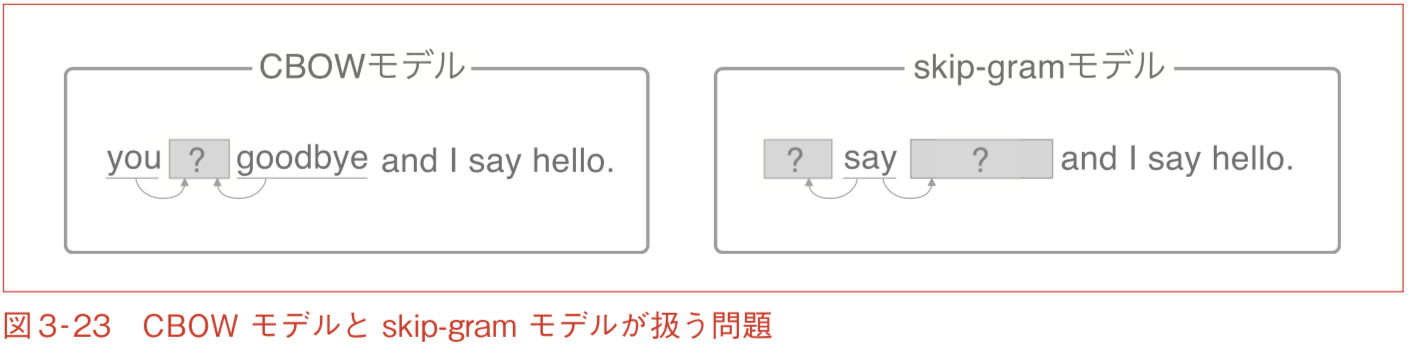

In [36]:
Image('images/NLP/fig3-23.png', width = 600)

図3-23に示すように, CBOW モデルはコンテキストが複数あり, その複数のコンテキストから中央の単語(ターゲット)を推測する. 一方, skip-gram モデルでは, ターゲットから, コンテキストを推測する. このとき, skip-gram モデルのネットワーク構成は図3-24のようになる.

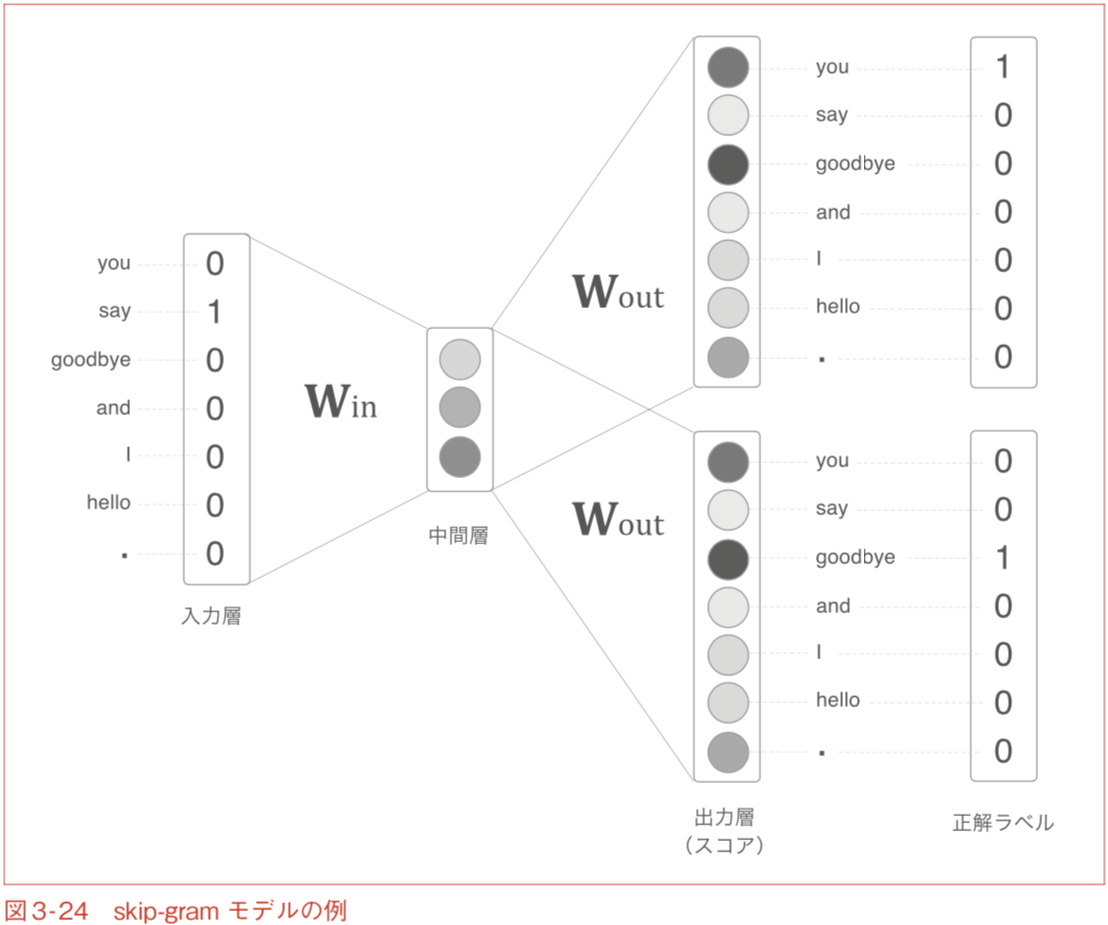

In [37]:
Image('images/NLP/fig3-24.png', width = 600)

図3-24に示すように, skip-gram モデルの入力層はひとつであり, 出力層はコンテキストの数だけ存在する. そのため, それぞれの出力層では個別に損失を求め, それらを足し合わせたものを最終的な損失とする. 

確率を使って, skip-gram モデル表す. ここで, ターゲット $w_t$ から, コンテキスト $w_{t-1}, w_{t+1}$ を推測する場合を考える. このとき, skip-gram は次の式(3.4)をモデル化する.

$$
    P(w_{t-1}, w_{t+1}|w_{t}) \tag{3.4}
$$

式(3.4)は $w_{t}$ が与えられたときに, $w_{t-1}$ と $w_{t+1}$が同時に起こる確率を表す. ここで skip-gram モデルでは, コンテキストの単語の間に関連性がないと仮定し, 次のように分解する. 

$$
    P(w_{t-1}, w_{t+1}|w_{t}) = P(w_{t-1}|w_{t})P(w_{t+1}|w_{t}) \tag{3.5}
$$

そして, 式(3.5)を交差エントロピー誤差に適用することで, skip-gram モデルの損失関数を導出する.

$$
    L = - \log{P(w_{t-1}, w_{t+1}|w_{t})} \\
      =  - \log{P(w_{t-1}|w_{t})P(w_{t+1}|w_{t})} \\
      = -(\log{P(w_{t-1}|w_{t})} + \log{P(w_{t+1}|w_{t})}) \tag{3.6}
$$

式(3.6)が示すように, skip-gram モデルの損失関数は, コンテキスト分の損失をそれぞれ求めて, それらを足し合わせたものになる. なお, 式(3.6)はサンプルデータひとつに対する skip-gram の損失関数であり, これをコーパス全体に拡張すると, skip-gram モデルの損失関数は次式(3.7)で表される.

$$
    L = - \frac{1}{T} \sum_{t = 1}^{T} (\log{P(w_{t-1}|w_t)} + \log{P(w_{t+1}|w_t)}) \tag{3.7}
$$

式(3.7)をCBOW モデルの式(3.3)と比較する. skip-gram モデルはコンテキストの数だけ推測をするため, その損失関数は書くコンテキストで求めた損失の総和を求める必要がある. 一方, CBOW モデル はひとつのターゲットの損失を求める. 以上が, skip-gram モデルの説明である.

CBOW モデルより skip-gram モデルのほうが 単語の分散表現の精度において, 多くの場合良い結果が得られる. 特にコーパスが大規模になるにつれて, 低頻出の単語や類推問題の性能の点において, skip-gram モデルのほうが優れた結果が得られる傾向にある. なお.学習速度の点では, CBOW モデルのほうが高速である. これは, skip-gram モデルでは, コンテキストの数だけ損失を求めるため, その計算コストが大きくなることに原因がある. 

### 3.5.3 カウントベース vs 推論ベース

カウントベースの手法は, コーパスの全体の統計データから1回の学習で単語の分散表現を取得した. 一方, 推論ベースでは, コーパスの一部を何度も見ながら学習した(ミニバッチ学習). ここでは, その他の点において, その2つの手法を比較しながら考察する.

まずはじめに, 語彙に新しい単語を追加するケースで, 単語の分散表現の更新作業が発生した場合を考える. このとき, カウントベースの手法では, ゼロから計算を行う必要がある. 仮に単語の分散表現を少しだけ修正したいとしても, 再度, 共起行列を作り直し, SVDを行うといった一連の作業が必要になる. それに対して, 推論ベースの手法 (word2vec) は, パラメータの再学習が行える. 具体的には, これまでに学習した重みを初期値として再学習することで, その学習した経験を損なわずに, 単語の分散表現の更新が効率的に行える. その点において, 推論ベースの手法のほうが優れている.

2つの手法で得られる単語の分散表現の性質や精度について考える. 分散表現の性質について言えば, カウントベースの手法では主に単語の類似性がエンコードされることが分かっている. 一方, word2vec では, 単語の類似性に加えて, されに複雑な単語間のパターンも捉えられることが分かっている. これは, word2vec の ｢king -man + woman = queen｣ のような類推問題を解けることで有名である.

ここでよくある誤解として, 推論ベースの手法が, カウントベースの手法よりも精度的に優れているということであるが, 実際のところ, 単語の類似性に関して言えば, 推論ベースとカウントベースの手法には優劣がつけられないことが報告されている.

また, 重要な事実として, 推論ベースの手法とカウントベースの手法には, 関連性があることが分かっている. 具体的には, skip-gram と Negative Sampling を利用したモデルは, コーパス全体の共起行列に対して特殊な行列分解をしているのと同じであることが示された. 

さらに word2vec 以降, 推論ベースとカウントベースの手法を融合させたような Glove という手法も提案されている. その手法のアイデアは, コーパス全体の
統計データの情報を損失関数に取り入れ, ミニバッチ学習をすることにある. それによって, 2つを融合させることに成功した.

## 3.6 まとめ

word2vec が提案されて以来, その有用性は多くの自然言語処理のタスクにおいて示されてきた. word2vec のCBOW モデルと呼ばれる基本的には2層のシンプルなニューラルネットワークについて説明, 実装を行い, 小さなコーパスで学習できることを確認した. しかし, 処理効率の面で問題があるため, 次章以降, この改良について考える.